In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as LA
import scipy.sparse.linalg as spLA

from scipy import sparse as sp

import sys
sys.path.insert(1, '../')

import SpringRank_tools as sr
import tools as tl

%load_ext autoreload
%aimport SpringRank_tools
%aimport tools
%autoreload 1

%matplotlib inline

## Generate a directed network

## Inferring ranks and group preferences


$$ H^{++} = H(s, \theta) + \tfrac{1}{2} \lambda_s ||s||_2^2 + \tfrac{1}{2} \lambda_{\theta} ||\theta||_2^2 $$

Want to solve:
$$\begin{align}
\nabla H^{++} &= 0 \\
\implies \nabla_s : \nabla_s H + \lambda_s s &= 0, \\
\nabla_{\theta} : \nabla_{\theta} H + \lambda_{\theta} \theta &= 0
\end{align}$$

Define:
$$\begin{align}
\Lambda_s &= \lambda_s I_{N} \\
\Lambda_{\theta} &= \lambda_{\theta} I_{k}
\end{align}$$

So, solve:
$$
\begin{bmatrix}
L + \Lambda_s & LG \\
G^T L & G^T LG + \Lambda_{\theta}
\end{bmatrix} \begin{bmatrix}
s \\
\theta \\
\end{bmatrix} = \begin{bmatrix}
\hat{d} \\
G^{T} \hat{d}
\end{bmatrix}
$$

In [32]:
def assign_groups(N, k, rand_seed=None):
    np.random.seed(rand_seed)
    groups = np.random.randint(0, k, N)
    G = np.zeros((N, k))
    for i, g_i in enumerate(groups):
        G[i, g_i] = 1
    
    return groups, G

def generate_ranks(N, G, s_params, theta_params, rand_seed=None):
    
    np.random.seed(rand_seed)
    s = np.random.normal(s_params[0], s_params[1], N)

    np.random.seed(rand_seed)
    theta = np.random.normal(theta_params[0], theta_params[1], G.shape[1])

    ranks = s + np.matmul(G, theta)
    
    return s, theta, ranks

def generate_network(N, beta, ranks, avg_degree, rand_seed=None):

    scaled_exp_energy = np.zeros((N, N))
    Z = 0
    for i in range(N):
        for j in range(N):
            energy_ij = 0.5 * np.power(ranks[i]-ranks[j]-1, 2)
            scaled_exp_energy[i, j] = np.exp(-beta * energy_ij)
            Z += scaled_exp_energy[i, j]
    c = float(avg_degree * N) / Z
    
    A = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i == j:
                continue

            lambda_ij = c * scaled_exp_energy[i, j]
            A[i, j] = np.random.poisson(lambda_ij)
            
    return A

In [82]:
def solve_springrank_sparse(A, G, lamb_s, lamb_theta, solver):
    
    # Get array shapes
    k = G.shape[1]
    N, M = A.shape
    assert(N == M)
    
    # Construct Laplacian
    k_in = np.sum(A, 0)
    k_out = np.sum(A, 1)
    D = np.diag(k_out + k_in)
    L = D - (A + A.T)
    
    # Make everything sparse
    L = sp.csr_matrix(L)
    G = sp.csr_matrix(G)
    I_n = sp.eye(N)
    I_k = sp.eye(k)
    
    # Construct the LHS matrix
    block_1 = L + lamb_s*I_n
    block_2 = L @ G
    block_3 = G.T @ L
    block_4 = G.T @ block_2 + lamb_theta*I_k
    top = sp.hstack([block_1, block_2])
    bot = sp.hstack([block_3, block_4])
    K = sp.vstack([top, bot])
    
    # Construct RHS vector (dense)
    d_top = k_out - k_in
    d_bot = np.matmul(G.T.toarray(), d_top)
    d_hat = np.append(d_top, d_bot, axis=0)
    
    # Solve using sparse or iterative solvers
    if solver == 'spsolve':
        x = spLA.spsolve(K, d_hat)
    elif solver == 'bicgstab':
        output = spLA.bicgstab(K, d_hat)
        x = output[0]
    elif solver == 'lsqr':
        output = spLA.lsqr(K, d_hat)
        x = output[0]
    else:
        output = spLA.bicgstab(K, d_hat)
        x = output[0]
    
    # Make x dense
    try:
        x = x.toarray()
    except AttributeError:
        pass
    
    ranks = {}
    ranks["individual_scores"] = x[:N]
    ranks["group_penalties"] = x[N:]
    
    return ranks

def solve_springrank_dense(A, G, lamb_s, lamb_theta):
    
    k = G.shape[1]
    N, M = A.shape
    assert(N == M)
    
    # Construct Laplacian
    d_out = np.sum(A, axis=1)
    d_in = np.sum(A, axis=0)
    D_out = np.diag(d_out)
    D_in = np.diag(d_in)
    L = D_out + D_in - (A + A.T)
    
    # Construct LHS matrix
    block_1 = L + lamb_s * np.eye(N)
    block_2 = np.matmul(L, G)
    block_3 = np.matmul(G.T, L)
    block_4 = np.matmul(G.T, block_2) + lamb_theta * np.eye(k)
    top = np.append(block_1, block_2, axis=1)
    bottom = np.append(block_3, block_4, axis=1)
    K = np.append(top, bottom, axis=0)
    
    # Construct RHS vector
    d_top = d_out - d_in
    d_bottom = np.matmul(G.T, d_top)
    d = np.append(d_top, d_bottom, axis=0)
    
    # Solve
    x, res, rank, eig = LA.lstsq(K, d, rcond=None)
    
    ranks = {}
    ranks["individual_scores"] = x[:N]
    ranks["group_penalties"] = x[N:]
    
    return ranks

def get_springranks(A, G, lamb_s, lamb_theta, sparse=True, solver='spsolve'):
    if sparse:
        x = solve_springrank_sparse(A, G, lamb_s, lamb_theta, solver)
    else:
        x = solve_springrank_dense(A, G, lamb_s, lamb_theta)
    
    N = A.shape[0]
    s = x["individual_scores"]
    theta = x["group_penalties"]
    ranks = s + np.matmul(G, theta)
    ranks = ranks - np.min(ranks)
    
    return s, theta, ranks

## Simulations

- Define an error function to tune for regularization coefficients?

In [4]:
N = 500
num_groups = 4
beta = 4
p_ij = 1 / (1 + np.exp(-2*beta))
l0 = 0.5
alpha = 1
s_params = (l0, 1./np.sqrt(alpha*beta))
l0_g = 0
alpha_g = 1
theta_params = (l0_g, 1./np.sqrt(alpha_g*beta))
K = 10

# groups, G = assign_groups(N, num_groups)
# s, theta, ranks = generate_ranks(N, G, s_params, theta_params)
# ranks = ranks - np.min(ranks)
# A = generate_network(N, beta, ranks, K)

A, G, s, theta, ranks = sr.SpringRank_planted_network_groups(
                            N, num_groups, beta, alpha, alpha_g, K, np.random, l0, l0_g, l1=1,
                            allow_self_loops=False, return_ranks=True)

A = np.array(nx.to_numpy_matrix(A))

<class 'numpy.matrix'>
<class 'numpy.ndarray'>


In [84]:
lamb_s = 1e-1
lamb_theta = 1e-1

s_est, theta_est, ranks_est = get_springranks(A, G, lamb_s, lamb_theta,
                                              sparse=True, solver='bicgstab')

print("    s mean: ", np.mean(s_est))
print("theta mean: ", np.mean(theta_est))

scaled_ranks = tl.adjust_ranks(ranks_est, A, p_ij=p_ij)

    s mean:  8.171241461241152e-17
theta mean:  1.9470536294363683e-14
1.0476428084674188


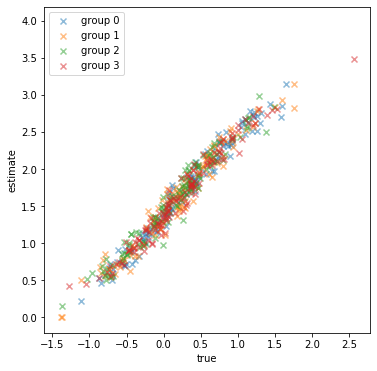

In [86]:
alpha = 0.5

plt.figure(figsize=(8,6))

for i in range(np.max(groups)+1):
    plt.scatter(ranks[groups==i],
                scaled_ranks[groups==i],
                marker='x', alpha=alpha,
                label="group {}".format(i))

plt.axis('square')
plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

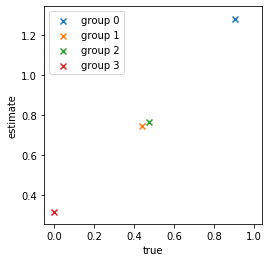

In [81]:
for i in range(np.max(groups)+1):
    plt.scatter(theta[i] - np.min(theta),
                theta_est[i] - np.min(theta),
                marker='x',
                label="group {}".format(i))

plt.axis('square')
plt.ylabel("estimate")
plt.xlabel("true")

plt.legend()

plt.show()

- How to recover $\beta$
- Things that we need to recover ranks
- Things that we need to recover group penalties
- Regularization - Identify correct regularization coefficients
- ~Use a sparse/iterative solver~
- See results for different $k, N$